In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

In [92]:
raw_df = pd.read_csv("data\CleanData.csv", index_col=0)

# Dealing with outliers

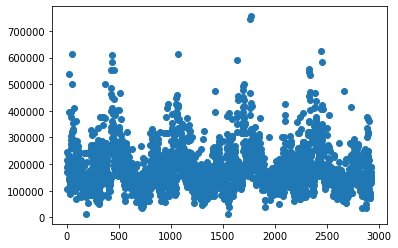

In [93]:
plt.scatter(x = raw_df.index, y = raw_df["SalePrice"])

In [94]:
min(raw_df["SalePrice"])

12789

In [95]:
len(raw_df)/100*2 #2% is ~ 58 records 

58.6

# We decided to remove 2% of the most expensive apartments and 2% of the cheapest ones

In [98]:
without_outliers = raw_df.sort_values(by="SalePrice")

In [99]:
without_outliers

,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,...,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice,Neighborhood full name
Order,,,,,,,,,,,,,,,,,,,,,
182,30,RM,9656,Pave,Reg,Lvl,AllPub,Inside,Gtl,OldTown,...,0,0,0,0,6,2010,WD,Abnorml,12789,Old Town
1554,20,A (agr),14584,Pave,Reg,Low,AllPub,Inside,Mod,IDOTRR,...,0,0,0,0,2,2008,WD,Abnorml,13100,Iowa DOT and Rail Road
727,30,C (all),7879,Pave,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,...,0,0,0,0,11,2009,WD,Abnorml,34900,Iowa DOT and Rail Road
2844,30,RL,8088,Pave,Reg,Lvl,AllPub,Inside,Gtl,Edwards,...,0,0,0,0,2,2006,ConLD,Normal,35000,Edwards
2881,20,C (all),9000,Pave,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,...,0,0,0,0,10,2006,WD,Abnorml,35311,Iowa DOT and Rail Road
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,20,RL,12919,Pave,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,...,0,0,0,0,3,2010,New,Partial,611657,Northridge Heights
1064,20,RL,12720,Pave,Reg,HLS,AllPub,Inside,Mod,NridgHt,...,0,216,144,0,2,2008,WD,Normal,615000,Northridge Heights
2446,60,RL,35760,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,NoRidge,...,0,0,0,0,7,2006,WD,Normal,625000,Northridge


In [100]:
without_outliers1 = without_outliers.head(2872)

In [101]:
without_outliers1

,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,...,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice,Neighborhood full name
Order,,,,,,,,,,,,,,,,,,,,,
182,30,RM,9656,Pave,Reg,Lvl,AllPub,Inside,Gtl,OldTown,...,0,0,0,0,6,2010,WD,Abnorml,12789,Old Town
1554,20,A (agr),14584,Pave,Reg,Low,AllPub,Inside,Mod,IDOTRR,...,0,0,0,0,2,2008,WD,Abnorml,13100,Iowa DOT and Rail Road
727,30,C (all),7879,Pave,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,...,0,0,0,0,11,2009,WD,Abnorml,34900,Iowa DOT and Rail Road
2844,30,RL,8088,Pave,Reg,Lvl,AllPub,Inside,Gtl,Edwards,...,0,0,0,0,2,2006,ConLD,Normal,35000,Edwards
2881,20,C (all),9000,Pave,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,...,0,0,0,0,10,2006,WD,Abnorml,35311,Iowa DOT and Rail Road
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,60,RL,46589,Pave,IR2,Lvl,AllPub,CulDSac,Gtl,NoRidge,...,0,0,0,0,7,2009,WD,Normal,402000,Northridge
431,20,RL,12220,Pave,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,...,0,0,0,0,9,2009,New,Partial,402861,Northridge Heights
496,60,RL,15138,Pave,IR1,Lvl,AllPub,Inside,Gtl,NoRidge,...,0,0,0,0,7,2009,WD,Normal,403000,Northridge


In [102]:
without_outliers2 = without_outliers1.tail(2814)

In [103]:
without_outliers2

,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,...,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice,Neighborhood full name
Order,,,,,,,,,,,,,,,,,,,,,
2289,160,RM,2001,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,...,0,0,0,0,1,2007,WD,Normal,75000,Meadow Village
944,30,C (all),10200,Pave,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,...,0,0,0,0,5,2009,WD,Normal,75000,Iowa DOT and Rail Road
2678,50,RM,6120,Pave,Reg,Lvl,AllPub,Inside,Gtl,BrkSide,...,0,0,0,0,11,2006,ConLI,Abnorml,75000,Brookside
2291,160,RM,1890,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,...,0,0,0,0,4,2007,COD,Normal,75190,Meadow Village
2238,30,RM,3672,Pave,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,...,0,0,0,0,9,2007,WD,Normal,75200,Iowa DOT and Rail Road
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,60,RL,46589,Pave,IR2,Lvl,AllPub,CulDSac,Gtl,NoRidge,...,0,0,0,0,7,2009,WD,Normal,402000,Northridge
431,20,RL,12220,Pave,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,...,0,0,0,0,9,2009,New,Partial,402861,Northridge Heights
496,60,RL,15138,Pave,IR1,Lvl,AllPub,Inside,Gtl,NoRidge,...,0,0,0,0,7,2009,WD,Normal,403000,Northridge


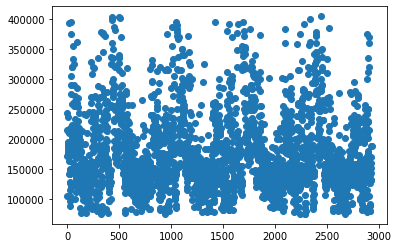

In [104]:
plt.scatter(x = without_outliers2.index, y = without_outliers2["SalePrice"])

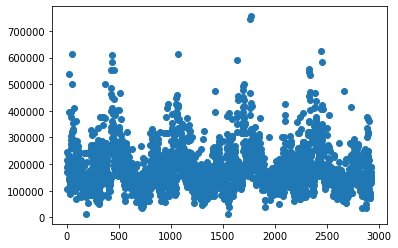

In [105]:
plt.scatter(x = raw_df.index, y = raw_df["SalePrice"])

# Dummies Variables with first column drop

In [122]:
dummies_df = pd.get_dummies(without_outliers2, drop_first = True)

# Spliting on X and y labels and train/test split with test size = 30%

In [123]:
y = dummies_df["SalePrice"]

In [124]:
X = dummies_df.drop(axis = 1, labels = "SalePrice")

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [126]:
X_train

,MS SubClass,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,1st Flr SF,2nd Flr SF,Low Qual Fin SF,...,Neighborhood full name_Northridge Heights,Neighborhood full name_Northwest Ames,Neighborhood full name_Old Town,Neighborhood full name_Sawyer,Neighborhood full name_Sawyer West,Neighborhood full name_Somerset,Neighborhood full name_South & West of Iowa State University,Neighborhood full name_Stone Brook,Neighborhood full name_Timberland,Neighborhood full name_Veenker
Order,,,,,,,,,,,,,,,,,,,,,
1452,20,7180,5,7,1972,1972,0.0,864,0,0,...,0,0,0,0,0,0,0,0,0,0
827,20,8814,7,5,2006,2006,180.0,1604,0,0,...,0,0,0,0,0,0,0,0,0,0
1780,20,10612,8,5,2006,2006,248.0,1534,0,0,...,0,0,0,0,0,1,0,0,0,0
970,20,12518,5,7,1968,1968,182.0,1008,0,0,...,0,0,0,0,0,0,0,0,0,0
759,50,5160,6,6,1927,1950,0.0,1204,462,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2587,80,7700,5,7,1956,1956,0.0,1145,0,0,...,0,0,0,0,0,0,0,0,0,0
2440,60,10852,6,5,2000,2000,0.0,959,712,0,...,0,0,0,0,0,0,0,0,0,0
1913,80,9600,6,5,1961,1961,291.0,1254,0,0,...,0,0,0,0,0,0,0,0,0,0


# Linear Regression

In [127]:
from sklearn.linear_model import LinearRegression

In [128]:
lm = LinearRegression()

In [129]:
lm.fit(X_train, y_train)

LinearRegression()

In [130]:
predictions = lm.predict(X_test)

In [131]:
from sklearn.metrics import r2_score

In [132]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 44748.31677191585
MSE: 3282646455.2398276
RMSE: 57294.3841509779


In [133]:
r2_score(y_test, predictions)

0.20097736938595645

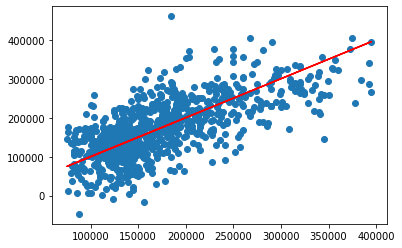

In [134]:
plt.scatter(y_test, predictions)

# Real Value
plt.plot(y_test, y_test, 'r')